# Cells integration - Nuclei mesenchymal

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
 palette = ["#E31A1C", "#1F78B4", "#A6CEE3",  "#B2DF8A", "#33A02C", "#FB9A99",  "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", "#66C2A5",
               "#FC8D62", "#8DA0CB", "#B3B3B3", "#A6D854", "#FFD92F", "#E5C494", "#E78AC3",
           '#f90492', '#f7d048', '#098474', '#505ba7', '#927306', '#6a5247']

#### Set up scVI environment

In [3]:
import scvi
import scanpy as sc
import anndata as ad

sc.set_figure_params(figsize=(4, 4))

In [4]:
import pandas as pd 
import numpy as np

# Read in dataset

## Nuclei
### Mareckova

In [5]:
data_dir = '/nfs/team292/lg18/endometriosis/raw_objects/'

adata = sc.read(data_dir+'/nuclei_rawcounts.h5ad')
adata.obs['dataset'] = 'Mareckova_Nuclei'
adata.X.shape

(591721, 33578)

In [6]:
adata = adata[['no' in i for i in adata.obs.discard_lowQC]]
adata.X.shape

(454152, 33578)

In [7]:
meta_barcodes = pd.read_csv('/nfs/team292/lg18/endometriosis/raw_objects/nuclei_Mareckova_barcodeinfo.csv',index_col=0)
# meta_barcodes = meta_barcodes[ meta_barcodes.n_genes > 1500 ]
meta_barcodes = meta_barcodes[ meta_barcodes.total_counts < 150000 ]
meta_barcodes = meta_barcodes[ meta_barcodes.total_counts > 3000 ]

pass_barcodes =  list(set(meta_barcodes.index) & set(adata.obs_names))
print(len(pass_barcodes))
print(len(meta_barcodes.index))

/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (15,21,23,24,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


372867
530656


In [8]:
adata = adata[ pass_barcodes ]
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
print('Total number of donors: {:d}'.format(len(set(adata.obs.genotype))))
print('Total number of samples: {:d}'.format(len(set(adata.obs['Library_genotype']))))
print('Total number of libraries: {:d}'.format(len(set(adata.obs['library']))))

Total number of cells: 372867
Total number of genes: 33578
Total number of donors: 63
Total number of samples: 68
Total number of libraries: 41


In [9]:
adata = adata[[ i in ['Endo_Superficial', 'Ctrl_Superficial', 'Ctrl_whole_uterus'] for i in adata.obs.Group ]]
adata = adata[[ i not in ['Myometrium'] for i in adata.obs.Tissue ]]

print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
print('Total number of donors: {:d}'.format(len(set(adata.obs.genotype))))
print('Total number of samples: {:d}'.format(len(set(adata.obs['Library_genotype']))))
print('Total number of libraries: {:d}'.format(len(set(adata.obs['library']))))

Total number of cells: 372867
Total number of genes: 33578
Total number of donors: 63
Total number of samples: 68
Total number of libraries: 41


## Subset to mesenchymals

In [10]:
annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/nuclei_endometrium.csv',index_col=0)
# annot_df.index = [ a.replace('-'+b, '') for a, b in zip(annot_df.index, annot_df.Type.tolist())]
annot_df.head()

annot = annot_df['Nuc_celltype'].to_dict()
adata.obs['Nuc_celltype'] = adata.obs_names.map(annot)
print(adata.obs['Nuc_celltype'].value_counts())

# del annot_df

Trying to set attribute `.obs` of view, copying.


Mesen_eStromal          108250
Epi_SOX9                 60556
Epi_Glandular            34810
Doublet                  32688
Mesen_dStromal           30060
Epi_Luminal              27730
Epi_preGlandular         26659
Immune_Lymphoid          16948
Immune_Myeloid           13895
Epi_endocervix_MUC5B      9371
Endothelial               5191
Epi_Ciliated              3197
Mesen_PV                  2217
LowQC                     1295
Name: Nuc_celltype, dtype: int64


In [11]:
adata = adata[[ 'Mesen_PV' in str(i) for i in  adata.obs['Nuc_celltype'] ]]
print(adata.obs['Nuc_celltype'].value_counts())

Mesen_PV    2217
Name: Nuc_celltype, dtype: int64


## Identify HVGs - on each dataset independently

!!! Unlike before (at least I think), now they recommend subsetting to highly variable genes before running scVI 

--> the tutorial says anywhere in between 1000 and 10,000 should be fine, so I arbitrarily chose 2000

In [12]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3"
)

Trying to set attribute `.uns` of view, copying.
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.var['highly_variable'] = df['highly_variable'].values
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.var['highly_variable_rank'] = df['highly_variable_rank'].values
/opt/conda/envs/scvi-singularity/li

In [13]:
# intersect independent HVGs
# hvg_Mareckova = cellsMareckova.var['highly_variable'].tolist()
# hvg_Tan = cellsTan.var['highly_variable'].tolist()

# hvg_both = [all(tup) for tup in zip(hvg_Mareckova, hvg_Tan)]
# sum(hvg_both)

In [14]:
# use HVGs computed by "dataset"
hvg_both = adata.var['highly_variable'].tolist()
sum(hvg_both)

2000

In [15]:
# subset object for scVI
bdata = adata[:, hvg_both ]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

In [16]:
print('Total number of highly_variable genes: {:d}'.format(bdata.n_vars))

Total number of highly_variable genes: 2000


## Normalize - optional

In [17]:
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# sc.pp.log1p(adata)

## scVI

!!! Here you can specify your covariates you want to correct for

In [18]:
scvi.data.setup_anndata(
    bdata,
    layer="counts",
    batch_key='genotype',
    categorical_covariate_keys=[ "library"]
)

INFO     Using batches from adata.obs["genotype"]                                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              


/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/scvi/data/_anndata.py:731: UserWarning: Category 41 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  category, alternate_column_key


INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2217 cells, 2000 vars, 61 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [19]:
# model = scvi.model.SCVI(bdata, n_latent= 64, n_layers=2, gene_likelihood="nb")
model = scvi.model.SCVI(bdata, n_latent= 64, n_layers=1)

In [20]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 64, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [21]:
model.train() #max_epochs = 400

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:59<00:00,  6.67it/s, loss=952, v_num=1]


In [22]:
latent = model.get_latent_representation()

In [23]:
adata.obsm["X_scVI"] = latent

## Save latent space

In [24]:
# del adata.obs['is_doublet']
# pd.DataFrame(adata.obsm["X_scVI"]).to_csv(data_dir+'/cells_nuclei_rawcounts_scVI_latentspace.csv')
# adata.write('/nfs/team292/datasets/hugodeca/integrated_female.h5ad')

### Visualization and Clustering

In [25]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.4)

/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Nuc_celltype' as categorical


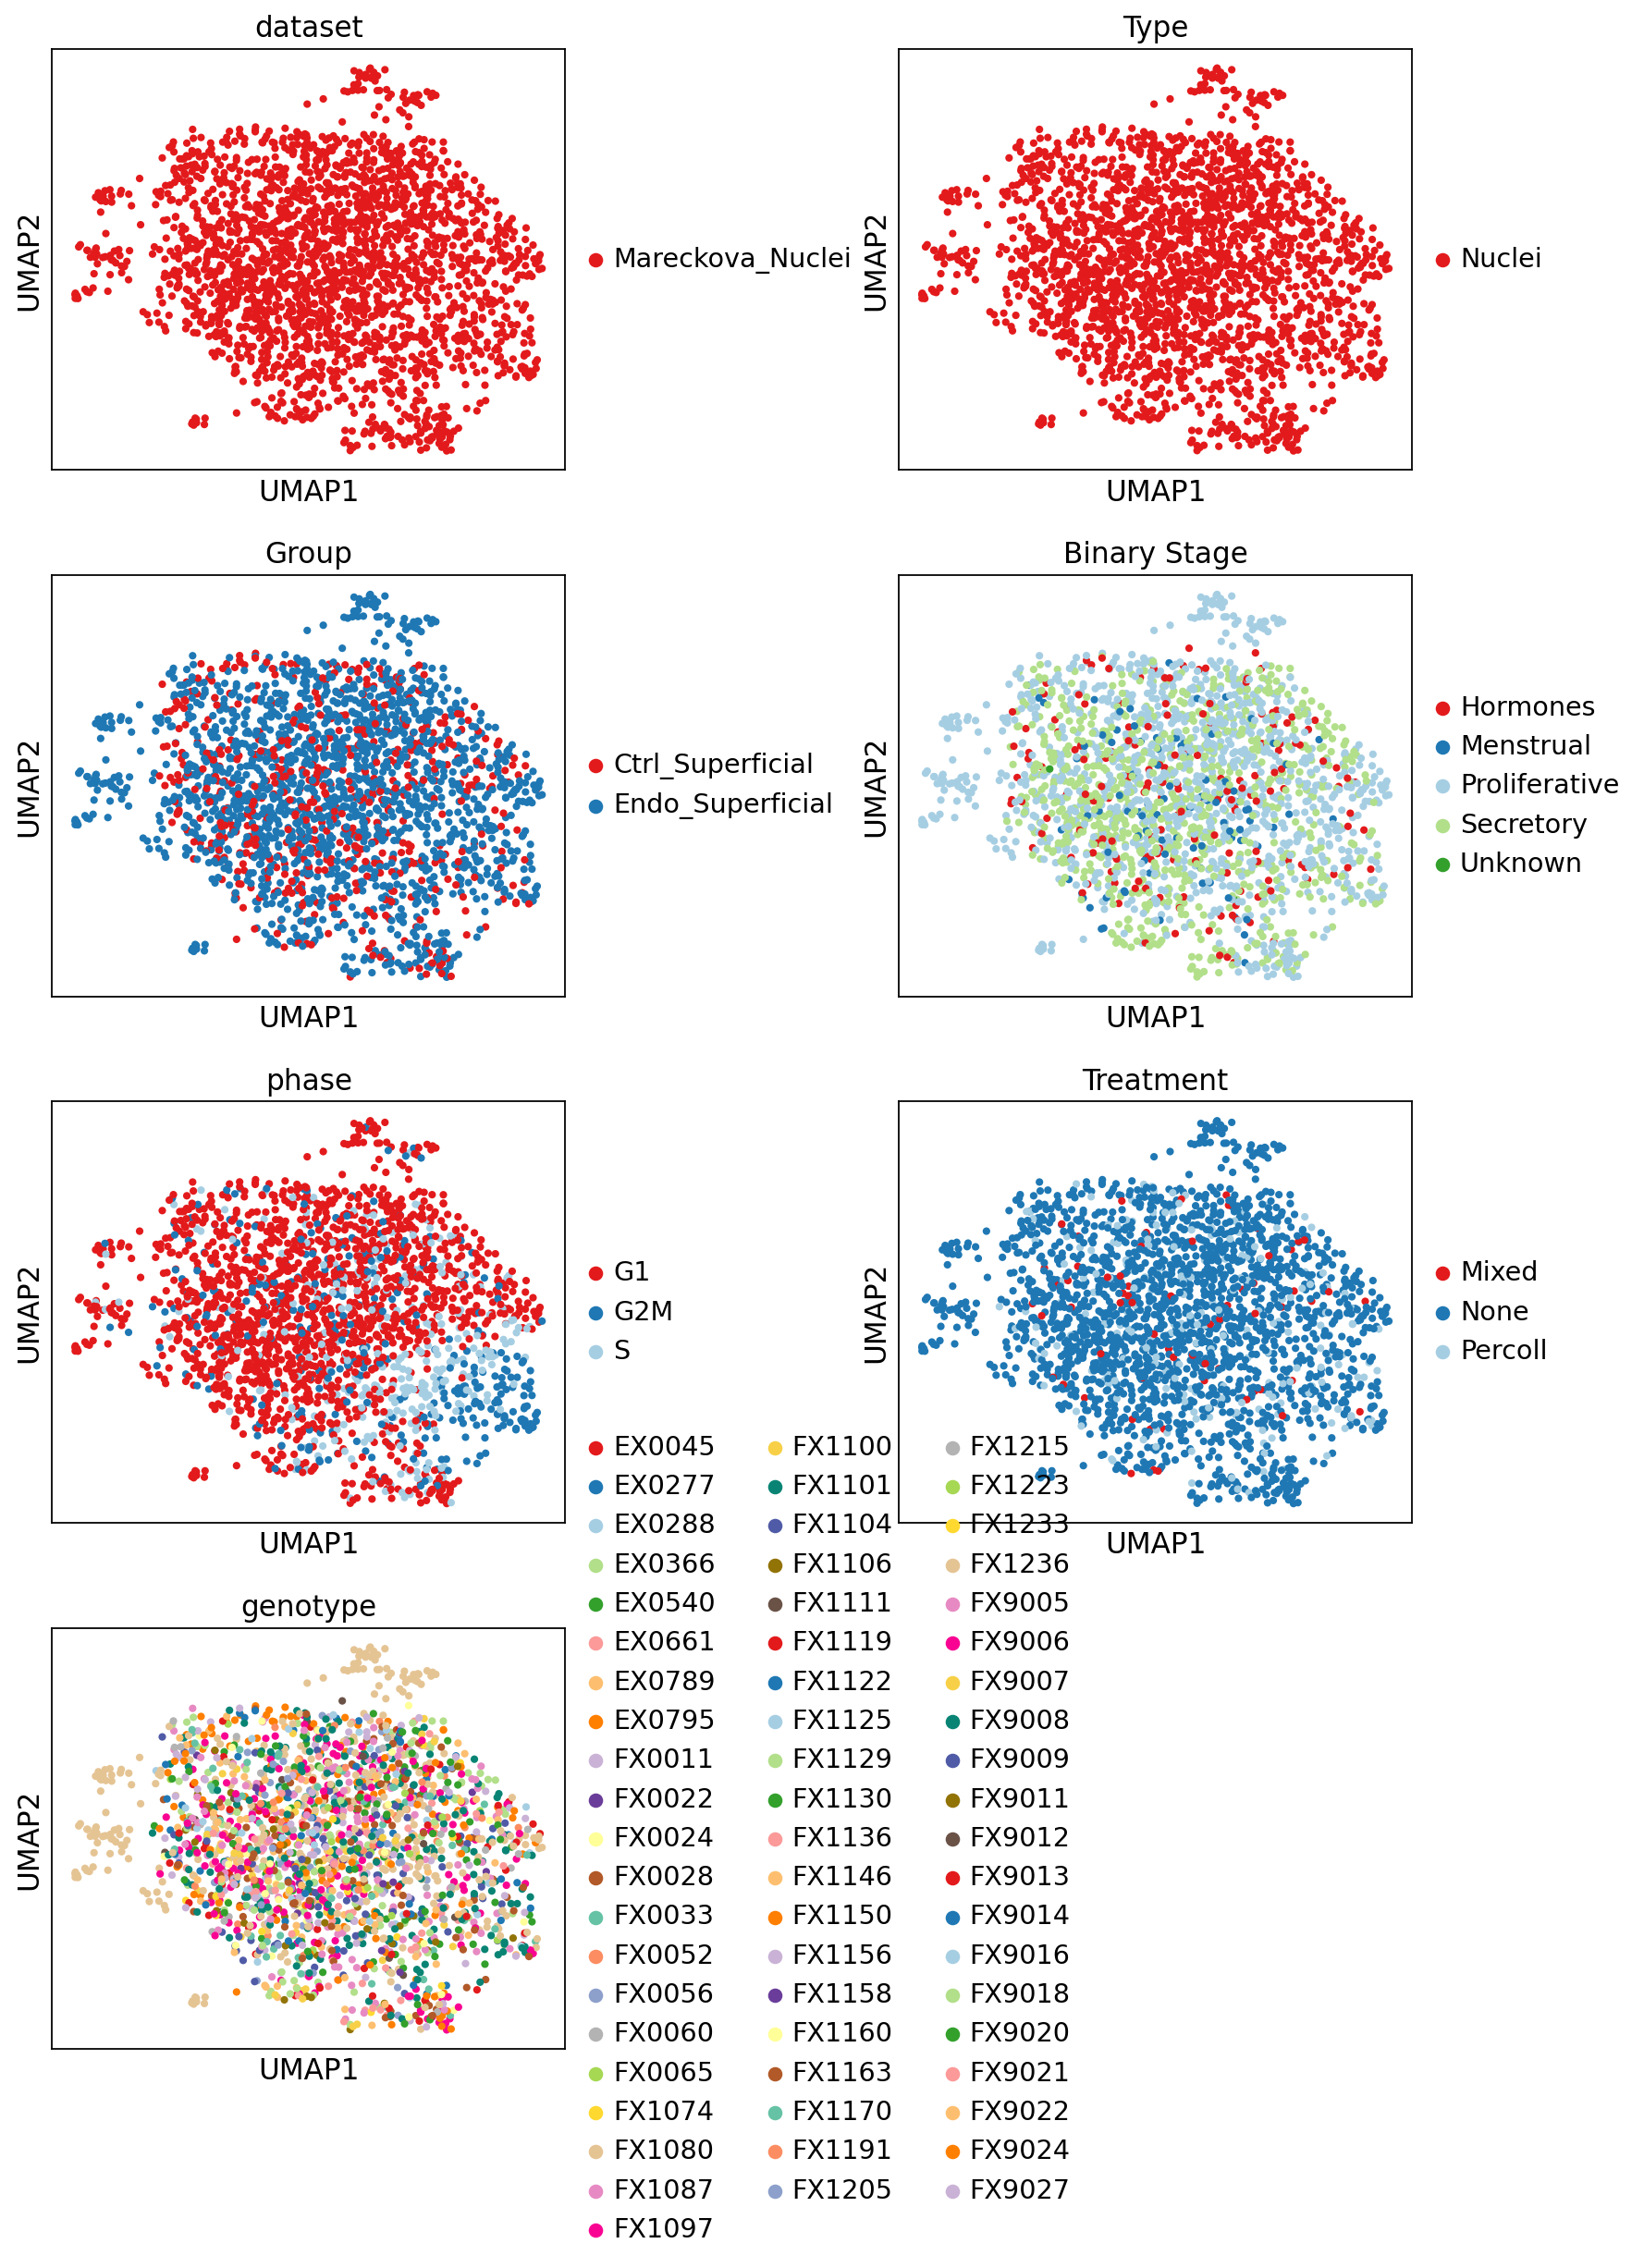

In [26]:
sc.pl.umap(
    sc.pp.subsample(adata, fraction=1, copy=True),
    color=['dataset', 'Type',  'Group', "Binary Stage", "phase", 'Treatment',  'genotype'], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.5
)

In [27]:
annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/labelTransfer_cell2nuc/epithelial/transferred_labels.csv',index_col=0)
annot_df.head()
annot_epi = annot_df['classifier'].to_dict()


annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/labelTransfer_cell2nuc/mesenchymal/transferred_labels.csv',index_col=0)
annot_df.head()
annot_mesen = annot_df['classifier'].to_dict()

annot = dict(annot_epi)
annot.update(annot_mesen)


adata.obs['LT_celltype'] = adata.obs_names.map(annot)
print(adata.obs['LT_celltype'].value_counts())

adata.obs['LT_epi_celltype'] = adata.obs_names.map(annot_epi)
print(adata.obs['LT_epi_celltype'].value_counts())

adata.obs['LT_mesen_celltype'] = adata.obs_names.map(annot_mesen)
print(adata.obs['LT_mesen_celltype'].value_counts())

ePV_MMP11             1470
ePV_AOC3               458
Fibroblast_basalis      91
mPV                     75
ePV_STEAP4              68
uSMCs                   14
eStromal_MMPs           11
dStromal_mid             4
Hormones                 2
eStromal                 2
dStromal_late            1
dStromal_early           1
Name: LT_celltype, dtype: int64
Series([], Name: LT_epi_celltype, dtype: int64)
ePV_MMP11             1470
ePV_AOC3               458
Fibroblast_basalis      91
mPV                     75
ePV_STEAP4              68
uSMCs                   14
eStromal_MMPs           11
dStromal_mid             4
Hormones                 2
eStromal                 2
dStromal_late            1
dStromal_early           1
Name: LT_mesen_celltype, dtype: int64


/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Nuc_celltype' as categorical
/opt/conda/envs/scvi-singularity/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be r

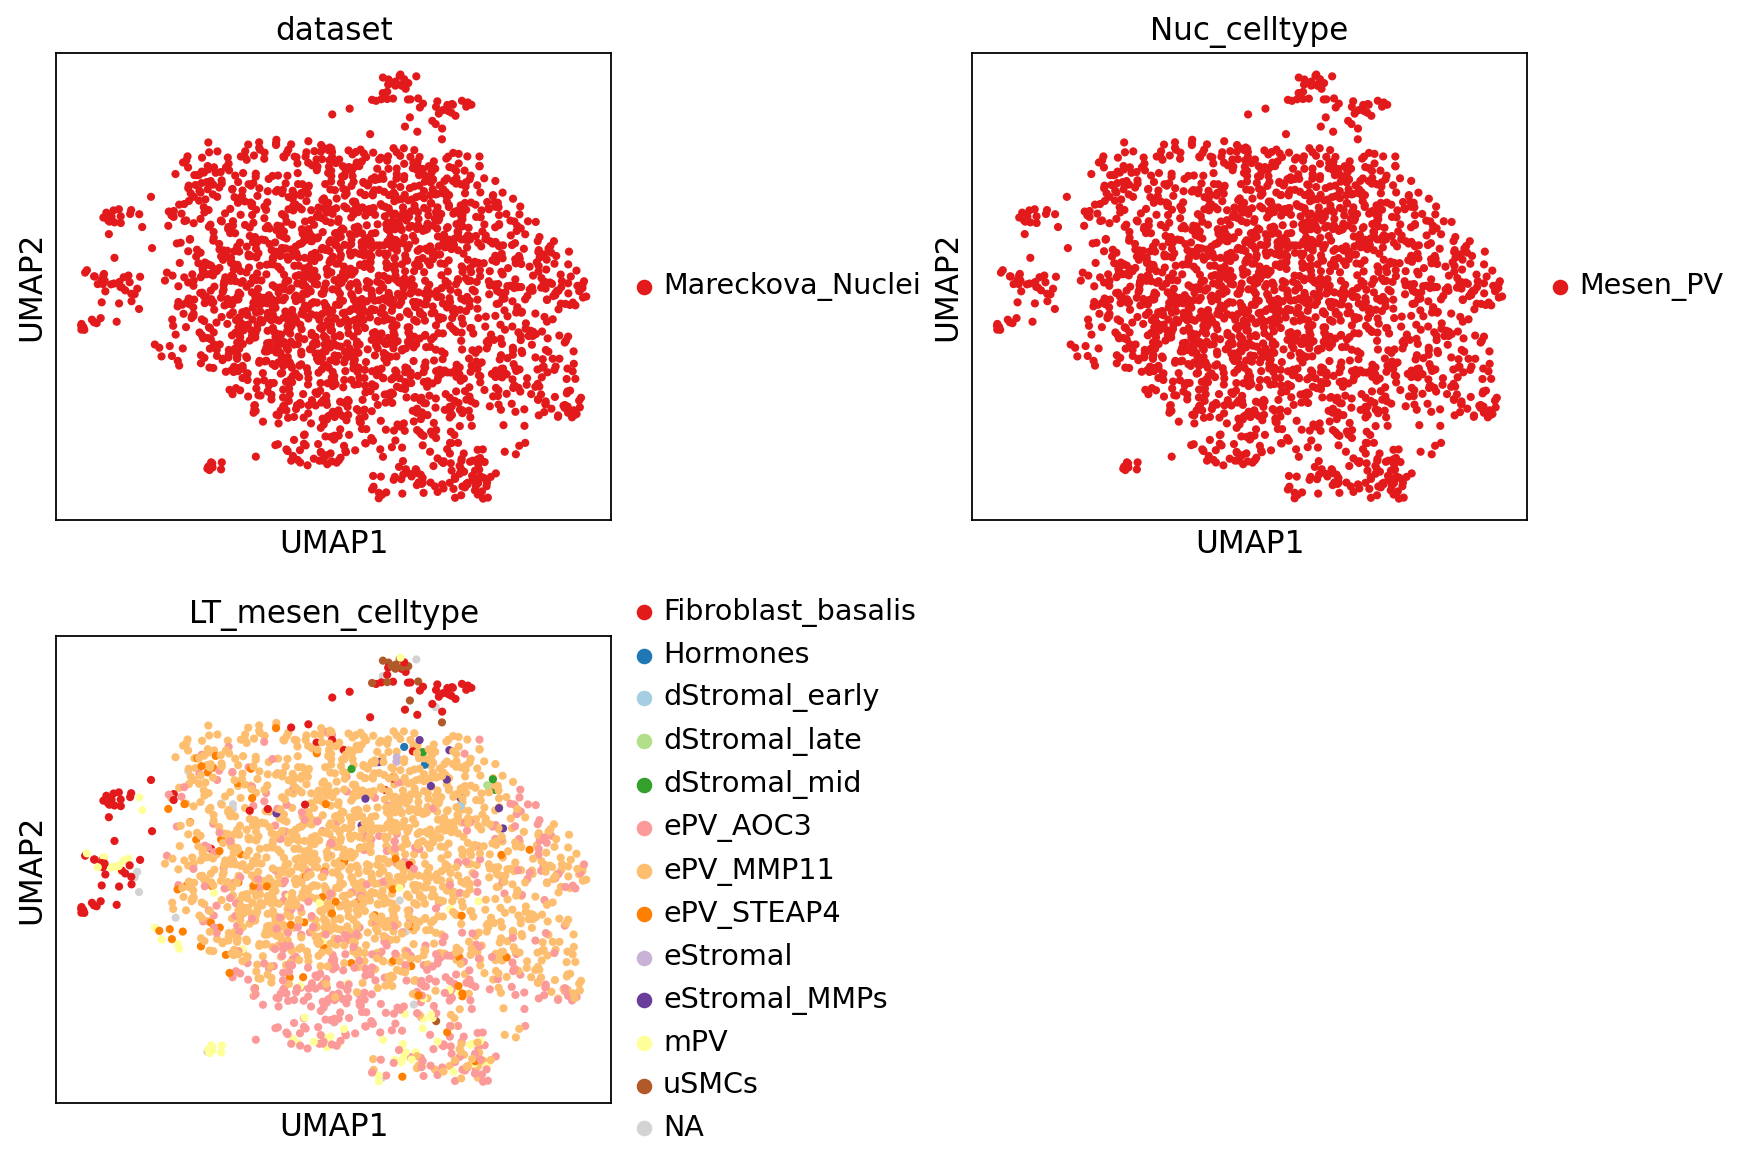

In [28]:
sc.pl.umap(
    adata,
    color=['dataset',  'Nuc_celltype', 'LT_mesen_celltype'], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.5
)

In [29]:
# sc.pl.umap(adata, color=["EPCAM", "PAX8", 'LGR5', 'FOXJ1', 'TP73', "DCN", "PDGFRA",  "MYH11",
#                          "PDGFRB", 'PTPRC', 'CDH5', 'HBA1', 'PAEP'], color_map='OrRd')

In [30]:
for i in adata.var.columns.tolist():
    if 'Nuclei' in i:
        print(i)
        del adata.var[i]
    if 'Cells' in i:
        print(i)
        del adata.var[i]

In [31]:
adata.write('/nfs/team292/lg18/endometriosis/integrated_objects/nuclei_PV_integrated.h5ad')